In [17]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.quantum_info import (
    Statevector,
    Operator,
    DensityMatrix,
    state_fidelity,
    partial_trace,
)
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    amplitude_damping_error,
    phase_damping_error,
)

# 0. Parameters

In [23]:
n_sys = 7                  # system qubits (spatial grid)
n_qubits = n_sys + 1       # total qubits = 1 control + n_sys system
N = 2**n_sys               # number of spatial grid points
times = [0.0, 0.3, 0.6, 0.9]
depth_PQC = int(np.floor(np.log2(n_sys+1))) + 1 

print(f"n_qubits = {n_qubits}, n_sys = {n_sys}, N = {N}, PQC depth = {depth_PQC}")

n_qubits = 8, n_sys = 7, N = 128, PQC depth = 4


# 1. Ricker wavelet |g(x)>

In [24]:
def ricker_target_state(n_sys, mu=0.5, Sigma=0.1):
    """
    Normalized Ricker (Mexican hat) wavelet over grid x in [0,1).
    """
    N = 2**n_sys
    x = np.arange(N) / N
    g = ((2 / (np.sqrt(3 * Sigma * np.pi))) ** 0.5) \
        * (1 - ((x - mu) / Sigma) ** 2) \
        * np.exp(-((x - mu) ** 2) / (2 * Sigma ** 2))
    g = g.astype(complex)
    g /= np.linalg.norm(g)
    return g

Target_Ricker = ricker_target_state(n_sys)

# Prepare |g> on the system register (qubits 1..n_sys)
# state_prep = StatePreparation(Target_Ricker)
# len(Target_Ricker)

## Parametrized Quantum Circuit (PQC)

In [25]:
# ================================================================
#  Full Brickwall PQC (3-CNOT entangling blocks, Fig. 5 in paper)
# ================================================================

# --- 1. Generic single-qubit unitary U1(α,β,γ) as a named gate
def U1_gate(a, b, c, label="U1"):
    sub = QuantumCircuit(1, name=label)
    sub.rz(a, 0)
    sub.ry(b, 0)
    sub.rz(c, 0)
    return sub.to_gate(label=label)


# --- 2. Three-CNOT entangling block as a named gate (matches Fig. 5 b)
#     Sequence: CNOT(0→1) → Rz(q0) → Ry(q1) → CNOT(1→0) → Ry(q1) → CNOT(0→1)
def entangling_block_gate(t7, t8, t9, label="Ent"):
    sub = QuantumCircuit(2, name=label)
    sub.cx(0, 1)        # first CNOT (q0→q1)
    sub.rz(t7, 0)       # Rz on control
    sub.ry(t8, 1)       # Ry on target
    sub.cx(1, 0)        # second CNOT (q1→q0)
    sub.ry(t9, 1)       # Ry on target again
    sub.cx(0, 1)        # third CNOT (q0→q1)
    return sub.to_gate(label=label)


# --- 3. Complete two-qubit block U^(m) as a named gate
#     2× pre-rotations, 3-CNOT entangler, 2× post-rotations → 15 parameters total
def two_qubit_block_gate(thetas, label="U^(m)"):
    """
    thetas = [θ1 ... θ15] (15 Parameter objects)
    """
    sub = QuantumCircuit(2, name=label)

    # Pre-rotations
    sub.append(U1_gate(thetas[0], thetas[1], thetas[2], label="U1_pre_q0"), [0])
    sub.append(U1_gate(thetas[3], thetas[4], thetas[5], label="U1_pre_q1"), [1])

    # Entangling section (3 CNOTs)
    sub.append(
        entangling_block_gate(
            thetas[6], thetas[7], thetas[8], label="Ent"
        ),
        [0, 1],
    )

    # Post-rotations
    sub.append(U1_gate(thetas[9],  thetas[10], thetas[11], label="U1_post_q0"), [0])
    sub.append(U1_gate(thetas[12], thetas[13], thetas[14], label="U1_post_q1"), [1])

    return sub.to_gate(label=label)


# --- 4. Assemble full brickwall PQC (Fig. 5 a), using named two-qubit blocks
def brickwall_PQC(n_qubits=4, depth=3):
    qc = QuantumCircuit(n_qubits)
    params = []
    param_index = 0

    for d in range(depth):
        # Alternate coupling pattern per layer: (0,1),(2,3) → (1,2) → repeat
        pairs = [(i, i + 1) for i in range(d % 2, n_qubits - 1, 2)]

        for (q0, q1) in pairs:
            # unique parameters for this two-qubit block
            thetas = [Parameter(f"θ{param_index + i}") for i in range(15)]
            params += thetas
            param_index += 15

            # Label block with layer + qubit pair, e.g. "U^0_(0,1)"
            block_label = f"U^{d}_({q0},{q1})"
            block_gate = two_qubit_block_gate(thetas, label=block_label)

            qc.append(block_gate, [q0, q1])

        # Optional: barrier between layers to visually separate them
        qc.barrier()

    return qc, params


## Training the PQC to Learn the Ricker Wavelet

In [26]:
# ================================================================
#  Brickwall PQC + Paper-Style Cost C(θ) + L-BFGS-B Training
# ================================================================

# ---------- Parameter binding (supports old/new Qiskit) ----------
def bind_params(qc, params, theta_vec):
    bind_map = {p: float(theta_vec[i]) for i, p in enumerate(params)} # This line builds a dictionary mapping each symbolic parameter such as {Parameter('θ0'): 0.47, Parameter('θ1'): 0.12, ...}
    return qc.assign_parameters(bind_map) # injects the numerical values into the circuit. fully specified circuit 𝑈(𝜃)

def psi_from_thetas(qc_template, params, theta_vec):
    qc = bind_params(qc_template, params, theta_vec)
    sv = Statevector.from_instruction(qc) 
    return sv.data  # complex vector length 2^n , the complex amplitude vector of the prepared quantum state

# ---------- Paper-style cost: C(θ) = 1 - Re( <g| U(θ) |0...0> ) ----------
def make_cost(qc_template, params, g_vec):
    """function wrapper for cost calculation inside the minimizer"""
    def cost(theta_vec):
        psi = psi_from_thetas(qc_template, params, theta_vec)
        overlap = np.vdot(g_vec, psi)           # <g|ψ(θ)>
        return 1.0 - np.real(overlap)           # paper’s objective
    return cost

def cost(theta_vec):
    """One time cost calculation"""
    bind_map = {p: float(theta_vec[i]) for i, p in enumerate(params_PQC)}
    qc_bound = qc.assign_parameters(bind_map)
    psi = Statevector.from_instruction(qc_bound).data
    overlap = np.vdot(Target_Ricker, psi)         # <g|ψ(θ)>
    return 1.0 - np.real(overlap)     # paper's cost function

# (Optional) report fidelity and overlap nicely
def report(qc_template, params, theta_vec, g_vec):
    psi = psi_from_thetas(qc_template, params, theta_vec)
    overlap = np.vdot(g_vec, psi)
    fidelity = np.abs(overlap) ** 2
    cost_val = 1.0 - np.real(overlap)
    print(f"Final cost C(θ): {cost_val:.6f}")
    print(f"Re(<g|ψ>): {np.real(overlap):.6f},  Im(<g|ψ>): {np.imag(overlap):.6f}")
    print(f"Fidelity |<g|ψ>|^2: {fidelity:.6f}")

In [27]:
qc_PQC, params_PQC = brickwall_PQC(n_qubits=n_sys, depth=depth_PQC)
print(f"PQC built: {n_sys} qubits, depth {depth_PQC}, parameters: {len(params_PQC)}")


# initial θ sampled uniformly from [0,1] as in the paper
rng = np.random.default_rng(7)
theta0 = rng.uniform(0.0, 1.0, size=len(params_PQC))

# build cost
cost = make_cost(qc_PQC, params_PQC, Target_Ricker)

# optimize with L-BFGS-B (increase maxiter toward 100_000 if you want to mirror the paper)
res = minimize(
    cost,
    theta0,
    method="L-BFGS-B",
    options=dict(maxiter=1000, ftol=1e-9, gtol=1e-8, maxcor=20, eps=1e-8)
)
 
print("\nOptimization status:", res.message)
print("Iterations:", res.nit)
print("Final cost:", res.fun)

theta_star_PQC = res.x
report(qc_PQC, params_PQC, theta_star_PQC, Target_Ricker)

# If you want the hardware-ready circuit with learned angles:
trained_qc_ricker = bind_params(qc_PQC, params_PQC, theta_star_PQC)
trained_qc_ricker.name = "Trained_PQC_ricker"

PQC built: 7 qubits, depth 4, parameters: 180

Optimization status: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Iterations: 81
Final cost: 0.012202460870604837
Final cost C(θ): 0.012202
Re(<g|ψ>): 0.987798,  Im(<g|ψ>): 0.002401
Fidelity |<g|ψ>|^2: 0.975750


## Ricker in Qunatum basis (PQC Result)

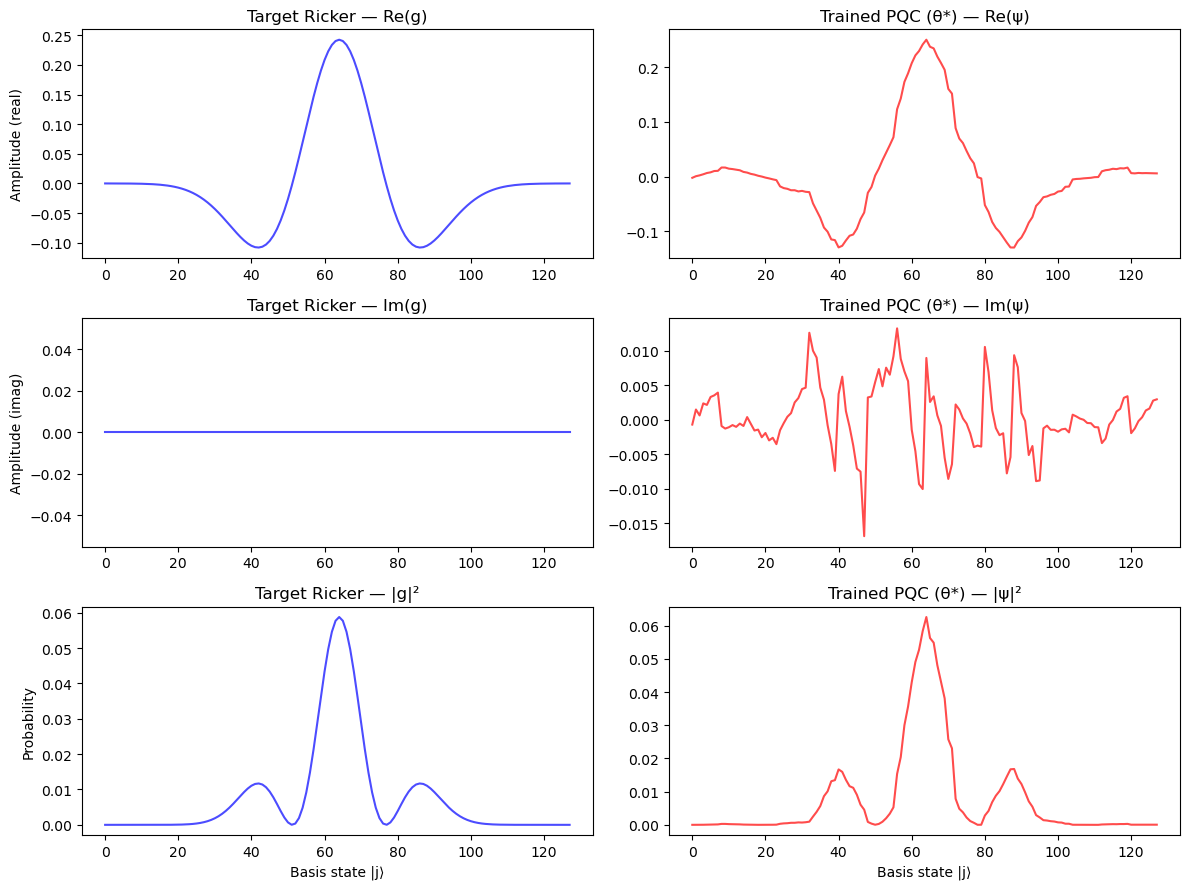

In [28]:
# ============================================================
#  Visualization: PQC at start (θ0), target, and trained (θ*)
# ============================================================

psi_trained_ricker = Statevector.from_instruction(trained_qc_ricker).data


# --- Prepare figure ---
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
x = np.arange(len(Target_Ricker))

# ===============================================
#  ROW 1 — Real part of amplitudes
# ===============================================
axs[0, 0].plot(x, Target_Ricker.real, color='blue', alpha=0.7)
axs[0, 0].set_title("Target Ricker — Re(g)")
axs[0, 0].set_ylabel("Amplitude (real)")

axs[0, 1].plot(x, psi_trained_ricker.real, color='red', alpha=0.7)
axs[0, 1].set_title("Trained PQC (θ*) — Re(ψ)")

# ===============================================
#  ROW 2 — Imaginary part of amplitudes
# ===============================================
axs[1, 0].plot(x, Target_Ricker.imag, color='blue', alpha=0.7)
axs[1, 0].set_title("Target Ricker — Im(g)")
axs[1, 0].set_ylabel("Amplitude (imag)")

axs[1, 1].plot(x, psi_trained_ricker.imag, color='red', alpha=0.7)
axs[1, 1].set_title("Trained PQC (θ*) — Im(ψ)")

# ===============================================
#  ROW 3 — Measurement probabilities |ψ|²
# ===============================================
axs[2, 0].plot(x, np.abs(Target_Ricker)**2, color='blue', alpha=0.7)
axs[2, 0].set_title("Target Ricker — |g|²")
axs[2, 0].set_xlabel("Basis state |j⟩")
axs[2, 0].set_ylabel("Probability")

axs[2, 1].plot(x, np.abs(psi_trained_ricker)**2, color='red', alpha=0.7)
axs[2, 1].set_title("Trained PQC (θ*) — |ψ|²")
axs[2, 1].set_xlabel("Basis state |j⟩")

# Improve layout and appearance
plt.tight_layout()
plt.show()

# 2. QFT and IQFT (standard little-endian)

In [29]:
def qft_qiskit(n):
    qc = QuantumCircuit(n, name="QFT")
    for j in range(n):
        qc.h(j)
        for k in range(j+1, n):
            qc.cp(np.pi / 2**(k-j), k, j)
    return qc

def iqft_qiskit(n):
    qc = QuantumCircuit(n, name="IQFT")
    for j in reversed(range(n)):
        for k in reversed(range(j+1, n)):
            qc.cp(-np.pi / 2**(k-j), k, j)
        qc.h(j)
    return qc

# 3. Time-evolution operator U_eq14(t)

In [30]:
def time_evolution_operator_eq14(t, n_qubits):
    """
    Implement Eq. (14) from the NISQ wave-equation paper.

    Qubit layout:
      - qubit 0 : control Z_0
      - qubit 1 : sign qubit
      - qubits 2..n_sys : magnitude bits

    n_sys = n_qubits - 1
    N = 2**n_sys
    """
    n_sys = n_qubits - 1
    N = 2**n_sys

    qc = QuantumCircuit(n_qubits, name=f"U_eq14(t={t})")

    # 1) Local phase: exp[-i t (2^{n-1} - 1) π Z0]
    alpha = (2**(n_sys - 1) - 1) * np.pi * t
    qc.rz(2 * alpha, 0)  # Rz(phi) = exp(-i phi Z/2)

    # 2) Sign-qubit block: |0><0|_1 + exp(i t N π Z0) |1><1|_1
    # Want exp(i β Z0) when sign qubit = 1, β = N π t.
    # Controlled-Rz(λ) on (control=1, target=0) gives exp(-i λ Z0/2).
    # So λ = -2β.
    beta = N * np.pi * t
    qc.crz(-2 * beta, 1, 0)

    # 3) ZZ couplings: Π_{q=2}^n exp(i t 2^{n-q} π Z0 Z_q)
    # Implement exp(i γ Z0 Z_q) as CX(0,q) Rz(-2γ)_q CX(0,q)
    for q in range(2, n_qubits):
        gamma_q = 2**(n_sys - q) * np.pi * t
        qc.cx(0, q)
        qc.rz(-2 * gamma_q, q)
        qc.cx(0, q)

    return qc

# 4. "Exact" spectral propagator for comparison

In [31]:
def fourier_matrix(N):
    k = np.arange(N)
    j = k[:, None]
    return np.exp(2j * np.pi * j * k / N) / np.sqrt(N)

F = fourier_matrix(N)
Fdag = F.conj().T

def spectral_propagator(t):
    """
    Build the 2N x 2N diagonal operator diag(e^{-it sqrt(-E_k)}, e^{+it sqrt(-E_k)}),
    as in the paper.
    """
    k = np.arange(N)
    Ek = -4 * N**2 * np.sin(np.pi * k / N)**2
    phases_pos = np.exp(-1j * t * np.sqrt(-Ek))  # top branch
    phases_neg = np.exp(+1j * t * np.sqrt(-Ek))  # bottom branch
    return np.diag(np.concatenate([phases_pos, phases_neg]))

def evolve_state_spectral(g_x, t):
    """
    Classical "exact" spectral evolution, analogue of Eq. (8).
    """
    # Embed |Φ(0)> = |0> ⊗ |g>  (second branch zero)
    Phi0 = np.zeros(2*N, dtype=complex)
    Phi0[:N] = g_x

    sv0 = Statevector(Phi0)

    H_top = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    H_top_big = np.kron(H_top, np.eye(N))

    U_diag = spectral_propagator(t)

    U = H_top_big @ np.kron(np.eye(2), F) @ U_diag @ np.kron(np.eye(2), Fdag) @ H_top_big

    evolved = sv0.evolve(Operator(U))
    amp = evolved.data.reshape(2, N)
    psi_t = amp[0]      # control = 0 branch
    return psi_t

# 5. Quick check: prepared initial |g> from Qiskit matches g_x

In [32]:
qc_init = QuantumCircuit(n_qubits)
qc_init.append(trained_qc_ricker, range(1, n_qubits))
sv_init = Statevector.from_instruction(qc_init)
psi_sys_init = sv_init.data[0::2]
print("Max diff between target g_x and prepared state:", np.max(np.abs(Target_Ricker - psi_sys_init)))

Max diff between target g_x and prepared state: 0.042507991387530114


# 6. Full evolution: Eq.(14) circuit vs exact spectral

In [41]:
# ------------------------------------------------------------
# 1. Build the full evolution circuit for given t
# ------------------------------------------------------------

def build_full_wave_circuit(t, n_qubits, trained_qc_ricker):
    """
    Build the full 1-step wave-equation circuit for time t:

      1. Prepare |g> on system qubits (1..n_qubits-1)
      2. H on control (q0)
      3. IQFT on system
      4. U_eq14(t) (Eq. 14 time-evolution block)
      5. QFT on system
      6. H on control

    Qubit layout:
      - qubit 0: control
      - qubits 1..n_sys: spatial grid register
    """
    n_sys = n_qubits - 1

    qc = QuantumCircuit(n_qubits)

    # Directly append the trained PQC circuit (can have barriers etc.)
    qc.append(trained_qc_ricker, range(1, n_qubits))

    # (H ⊗ IQFT)
    qc.h(0)
    qc.append(iqft_qiskit(n_sys), range(1, n_qubits))

    # Diagonal time-evolution block U_eq14(t)
    qc.append(time_evolution_operator_eq14(t, n_qubits), range(n_qubits))

    # (H ⊗ QFT)
    qc.append(qft_qiskit(n_sys), range(1, n_qubits))
    qc.h(0)

    return qc


# ------------------------------------------------------------
# 2. Noise models: depolarizing, phase damping, amplitude damping
# ------------------------------------------------------------

def build_noise_models(p_depol_1q=5e-3, p_depol_2q=1e-2,
                       gamma_phase=5e-3, gamma_amp=5e-3):
    """
    Build three different noise models:
      - 'depolarizing': depolarizing noise on 1q and 2q gates
      - 'phase_damping': phase damping on 1q gates
      - 'amplitude_damping': amplitude damping on 1q gates
    """

    # --- 1) Depolarizing noise model ---
    nm_depol = NoiseModel()
    depol_1q = depolarizing_error(p_depol_1q, 1)
    depol_2q = depolarizing_error(p_depol_2q, 2)

    one_qubit_gates = ['h', 'rz', 'ry', 'x']
    two_qubit_gates = ['cx']

    for g in one_qubit_gates:
        nm_depol.add_all_qubit_quantum_error(depol_1q, [g])
    for g in two_qubit_gates:
        nm_depol.add_all_qubit_quantum_error(depol_2q, [g])

    # --- 2) Phase damping noise model ---
    nm_phase = NoiseModel()
    phase_err = phase_damping_error(gamma_phase)
    for g in one_qubit_gates:
        nm_phase.add_all_qubit_quantum_error(phase_err, [g])

    # --- 3) Amplitude damping noise model ---
    nm_amp = NoiseModel()
    amp_err = amplitude_damping_error(gamma_amp)
    for g in one_qubit_gates:
        nm_amp.add_all_qubit_quantum_error(amp_err, [g])

    noise_models = {
        "depolarizing": nm_depol,
        "phase_damping": nm_phase,
        "amplitude_damping": nm_amp,
    }
    return noise_models


def build_noisy_simulators(noise_models):
    """
    For each noise model, build an AerSimulator using the density_matrix method.
    """
    simulators = {}
    for name, nm in noise_models.items():
        sim = AerSimulator(
            method='density_matrix',
            noise_model=nm,
            basis_gates=nm.basis_gates
        )
        simulators[name] = sim
    return simulators

# ------------------------------------------------------------
# 3. Helpers for ideal / noisy states and fidelities
# ------------------------------------------------------------

def ideal_statevector(qc):
    """
    Return ideal pure state |psi> from the circuit qc.
    IMPORTANT: decompose custom gates into basis gates so that
    no high-level instructions remain.
    """
    qc_decomp = qc.decompose(reps=10)
    return Statevector.from_instruction(qc_decomp)


def noisy_density_matrix(qc, simulator):
    """
    Run qc on a noisy density-matrix simulator and return the final DensityMatrix.
    IMPORTANT: decompose custom gates into basis gates first;
    otherwise Aer may see unknown instructions.
    """
    qc_noisy = qc.decompose(reps=10)
    qc_noisy.save_density_matrix()

    result = simulator.run(qc_noisy).result()
    data = result.data(0)
    rho = data['density_matrix']
    return DensityMatrix(rho)


def fidelity_full_and_branch(psi_ideal, rho_noisy, n_sys):
    """
    Compute:
      - F_full: fidelity between full pure state |psi> and rho_noisy
      - F_sys: fidelity between control=0 branch (system-only) and
               reduced noisy density matrix on system qubits.
    """
    # Full-state fidelity
    F_full = state_fidelity(psi_ideal, rho_noisy)

    # --- System-only fidelity (control = 0 branch) ---
    # Take control=0 amplitudes from ideal state
    psi_data = psi_ideal.data
    psi_sys_vec = psi_data[0::2]   # even indices → control = 0
    psi_sys_vec = psi_sys_vec / np.linalg.norm(psi_sys_vec)
    psi_sys = Statevector(psi_sys_vec)

    # Reduce noisy density matrix by tracing out control qubit (qubit 0)
    rho_sys = partial_trace(rho_noisy, [0])

    F_sys = state_fidelity(psi_sys, rho_sys)

    return F_full, F_sys


def extract_psi_branch(state, n_sys):
    """
    Extract ψ(x,t) = control-0 branch.
    Works for:
      - Statevector (pure)
      - DensityMatrix (mixed)
    """
    if isinstance(state, Statevector):
        # even indices → control = 0 branch
        psi = state.data[0::2]
        return psi

    elif isinstance(state, DensityMatrix):
        # trace out control qubit → reduced system density matrix
        rho_sys = partial_trace(state, [0])
        probs = np.real(np.diagonal(rho_sys.data))
        # return sqrt(probabilities) (amplitudes cannot carry phase)
        return np.sqrt(probs)

    else:
        raise ValueError("state must be a Statevector or DensityMatrix")


# 7. Noise addition and comparison

In [48]:
# ------------------------------------------------------------
# 4. Main sweep: fidelity + amplitudes vs time for each noise type
# ------------------------------------------------------------

noise_models = build_noise_models(
    p_depol_1q=5e-3,
    p_depol_2q=1e-2,
    gamma_phase=5e-5,
    gamma_amp=5e-3,
)
noisy_sims = build_noisy_simulators(noise_models)

results_fid = {}  
# structure becomes:
# {
#   'depolarizing': {
#       't': [...],
#       'F_full': [...],
#       'F_sys': [...],
#       'psi_ideal': [ array ψ(x,t0), array ψ(x,t1), ... ],
#       'psi_noisy': [ array ψ_noisy(x,t0), array ψ_noisy(x,t1), ... ]
#   },
#   ...
# }

for noise_name, sim in noisy_sims.items():
    print(f"\nRunning noisy simulations for noise type: {noise_name}")
    
    t_list = []
    F_full_list = []
    F_sys_list = []
    psi_ideal_list = []
    psi_noisy_list = []

    for t in times:
        print(f"  t = {t}")
        qc = build_full_wave_circuit(t, n_qubits, trained_qc_ricker)

        # Ideal pure state
        psi_ideal_full = ideal_statevector(qc)
        psi_ideal = extract_psi_branch(psi_ideal_full, n_sys)

        # Noisy mixed state
        rho_noisy = noisy_density_matrix(qc, sim)
        psi_noisy = extract_psi_branch(rho_noisy, n_sys)

        # Fidelity metrics
        F_full, F_sys = fidelity_full_and_branch(psi_ideal_full, rho_noisy, n_sys)

        # Store values
        t_list.append(t)
        F_full_list.append(F_full)
        F_sys_list.append(F_sys)
        psi_ideal_list.append(psi_ideal)
        psi_noisy_list.append(psi_noisy)

    results_fid[noise_name] = {
        "t": np.array(t_list),
        "F_full": np.array(F_full_list),
        "F_sys": np.array(F_sys_list),
        "psi_ideal": psi_ideal_list,
        "psi_noisy": psi_noisy_list,
    }



Running noisy simulations for noise type: depolarizing
  t = 0.0
  t = 0.3
  t = 0.6
  t = 0.9

Running noisy simulations for noise type: phase_damping
  t = 0.0
  t = 0.3
  t = 0.6
  t = 0.9

Running noisy simulations for noise type: amplitude_damping
  t = 0.0
  t = 0.3
  t = 0.6
  t = 0.9


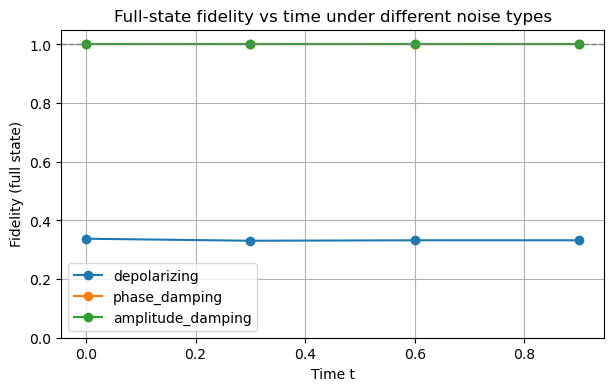

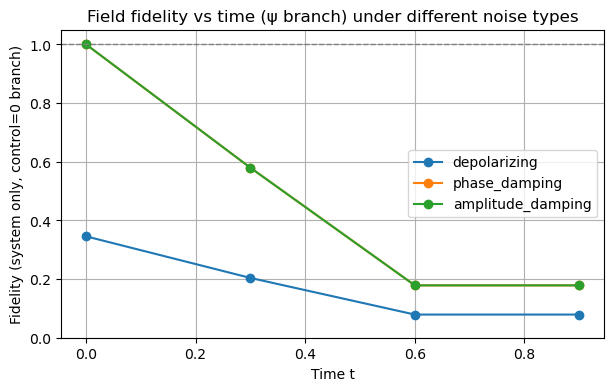

In [49]:

# ------------------------------------------------------------
# 5. Plots: fidelity vs t
# ------------------------------------------------------------

# Full-state fidelity
plt.figure(figsize=(7, 4))
for noise_name, data in results_fid.items():
    plt.plot(data["t"], data["F_full"], marker="o", label=f"{noise_name}")
plt.axhline(1.0, linestyle="--", linewidth=1, color="gray")
plt.ylim(0.0, 1.05)
plt.xlabel("Time t")
plt.ylabel("Fidelity (full state)")
plt.title("Full-state fidelity vs time under different noise types")
plt.legend()
plt.grid(True)
plt.show()

# System-only (control=0 branch) fidelity
plt.figure(figsize=(7, 4))
for noise_name, data in results_fid.items():
    plt.plot(data["t"], data["F_sys"], marker="o", label=f"{noise_name}")
plt.axhline(1.0, linestyle="--", linewidth=1, color="gray")
plt.ylim(0.0, 1.05)
plt.xlabel("Time t")
plt.ylabel("Fidelity (system only, control=0 branch)")
plt.title("Field fidelity vs time (ψ branch) under different noise types")
plt.legend()
plt.grid(True)
plt.show()


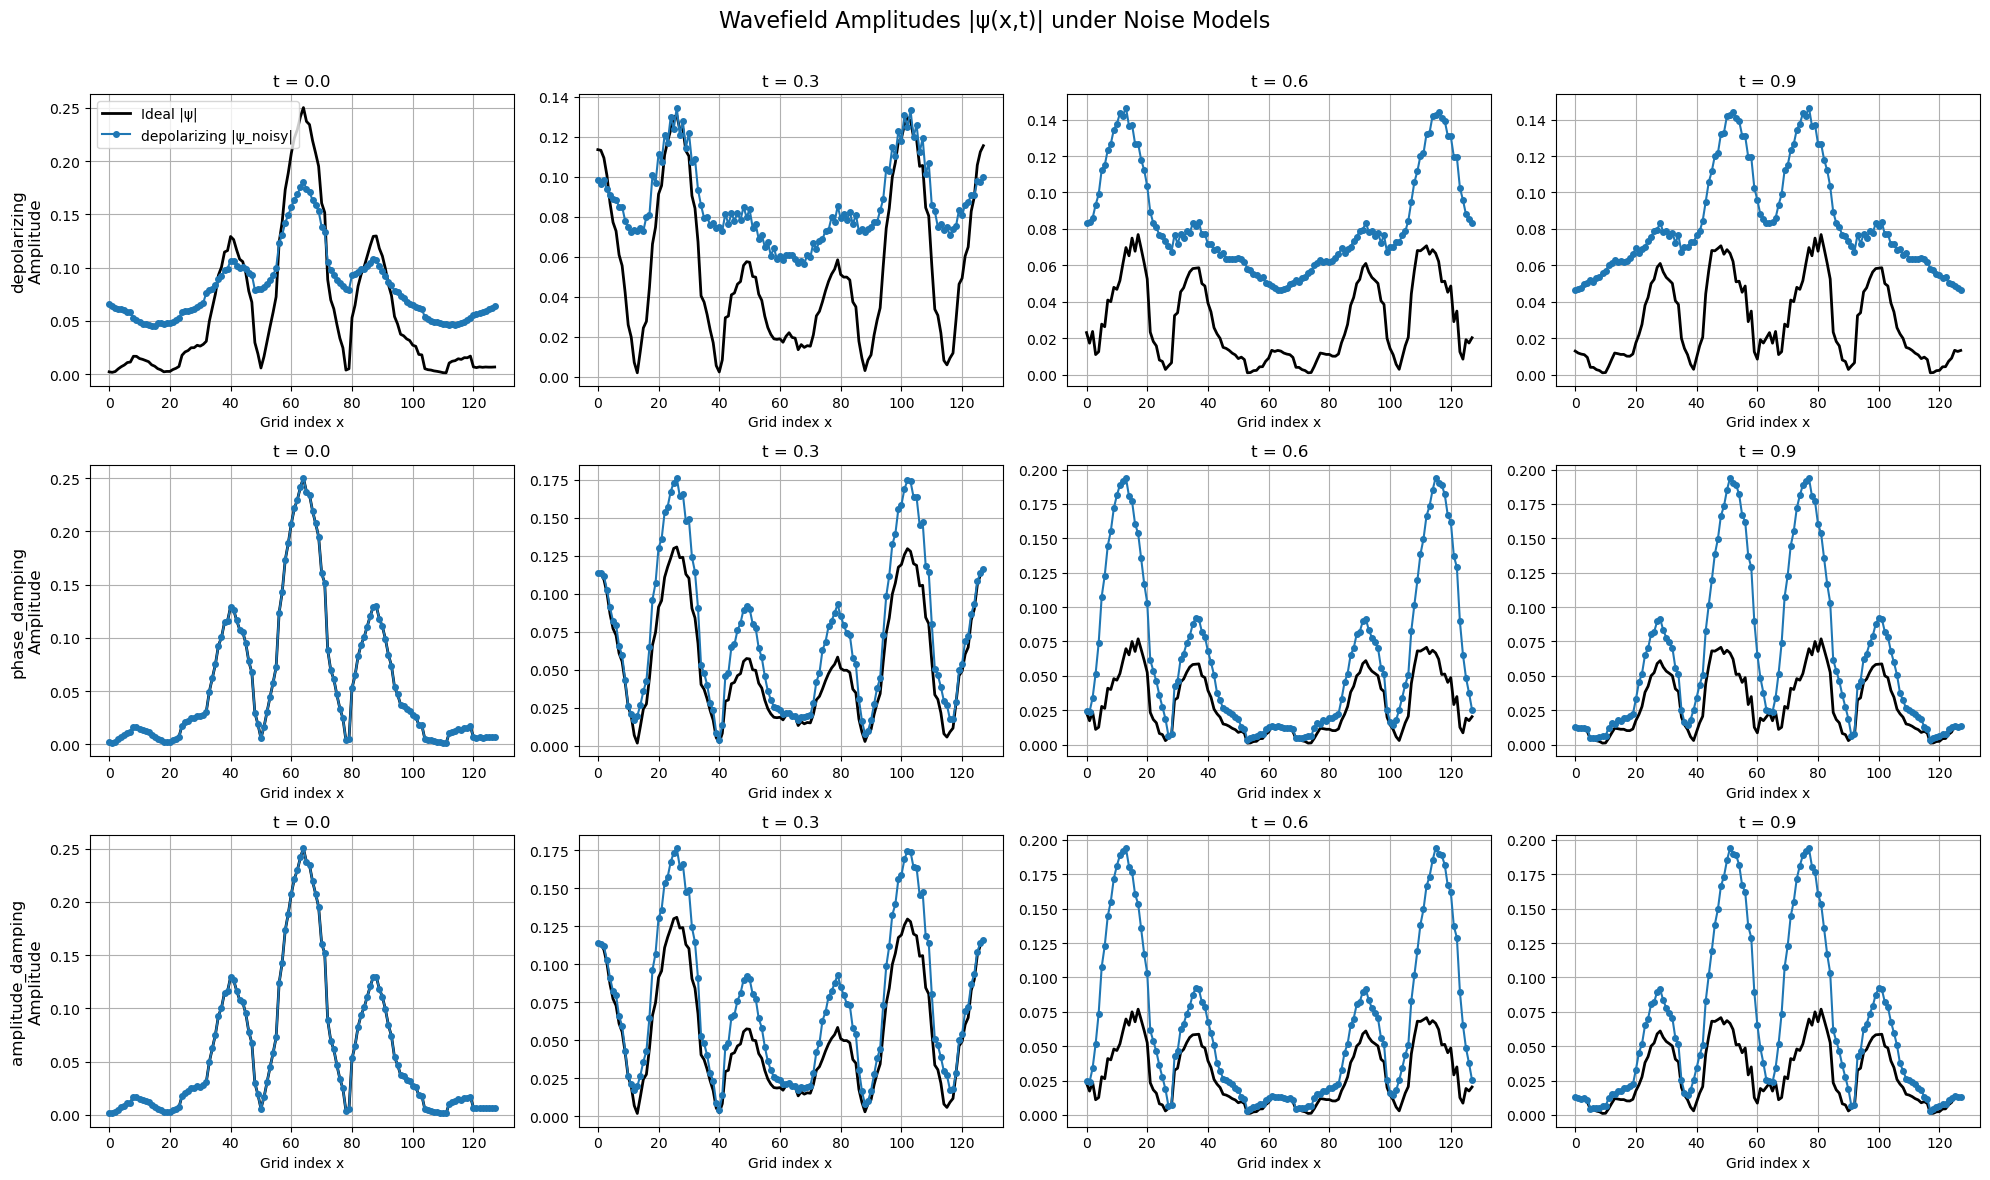

In [50]:
# ============================================================
# Plot ψ(x,t) as a grid: each row = noise type, each column = time
# ============================================================

num_noise = len(results_fid)
num_t = len(times)

fig, axes = plt.subplots(num_noise, num_t, figsize=(5*num_t, 4*num_noise), squeeze=False)

for row, (noise_name, data) in enumerate(results_fid.items()):
    for col, t in enumerate(data["t"]):

        ax = axes[row, col]

        psi_ideal = data["psi_ideal"][col]
        psi_noisy = data["psi_noisy"][col]
        x = np.arange(len(psi_ideal))

        # Plot |ψ|
        ax.plot(x, np.abs(psi_ideal), 'k-', linewidth=2, label="Ideal |ψ|")
        ax.plot(x, psi_noisy, 'o-', markersize=4, label=f"{noise_name} |ψ_noisy|")

        # Labels & titles
        if col == 0:
            ax.set_ylabel(f"{noise_name}\nAmplitude", fontsize=12)
        ax.set_title(f"t = {t}", fontsize=12)

        ax.set_xlabel("Grid index x")
        ax.grid(True)

        # Legend only on top-left panel for cleanliness
        if row == 0 and col == 0:
            ax.legend()

plt.suptitle("Wavefield Amplitudes |ψ(x,t)| under Noise Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
